In [1]:
import math
import numpy as np
import pickle
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops

%matplotlib inline

### 载入数据集

In [2]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

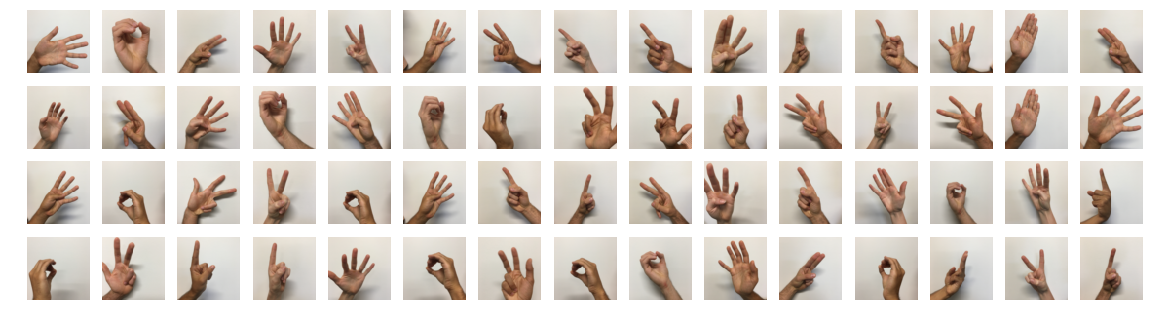

In [4]:
# 绘制训练样本图片集 前60张
X_orig = X_train_orig[:60]
num_images = X_orig.shape[0]
row = 15
col = np.ceil(num_images / row)
plt.figure(figsize=(20, 20 * col / row))
for i, img in enumerate(X_orig):
    plt.subplot(col, row, i + 1)
    plt.imshow(img, interpolation='nearest')
    plt.axis('off')

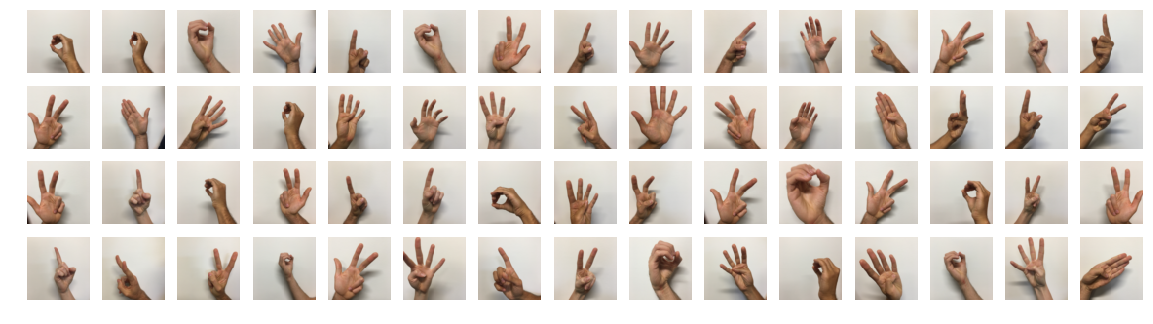

In [5]:
# 绘制测试样本图片集 前60张
X_orig = X_test_orig[:60]
num_images = X_orig.shape[0]
row = 15
col = np.ceil(num_images / row)
plt.figure(figsize=(20, 20 * col / row))
for i, img in enumerate(X_orig):
    plt.subplot(col, row, i + 1)
    plt.imshow(img, interpolation='nearest')
    plt.axis('off')

### 标准化输入

In [6]:
# Flatten the training and test images
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T
# Normalize image vectors
X_train = X_train_flatten / 255.
X_test = X_test_flatten / 255.
# Convert training and test labels to one hot matrices
Y_train = np.eye(6)[Y_train_orig.reshape(-1)].T
Y_test = np.eye(6)[Y_test_orig.reshape(-1)].T
# 以下tf语句和上面两行代码作用一样
# with tf.Session() as sess:
#     Y_train = sess.run(tf.one_hot(Y_train_orig[0], 6, axis=0))
#     Y_test = sess.run(tf.one_hot(Y_test_orig[0], 6, axis=0))

print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (12288, 1080)
Y_train shape: (6, 1080)
X_test shape: (12288, 120)
Y_test shape: (6, 120)


### 深层神经网络（ReLU->ReLU->...->ReLU->Softmax）

In [7]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    assert(X.shape[1] == Y.shape[1])
    
    if seed > 0:
        np.random.seed(seed)
    
    m = X.shape[1] # number of training examples
    mini_batches = []
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m / mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : (k + 1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : (k + 1) * mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : ]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : ]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [8]:
def print_all_test_images(p, y):
    num_images = len(X_test_orig)
    row = 15
    col = np.ceil(num_images / row)
    plt.rcParams['figure.figsize'] = (20, 25 * col / row)
    for i in range(num_images):
        plt.subplot(col, row, i + 1)
        plt.imshow(X_test_orig[i], interpolation='nearest')
        plt.axis('off')
        if p[i] != y[i]:
            plt.title("%d (%d)" % (p[i], y[i]), color='red', fontweight='bold')

In [9]:
def nn_model(X_train, Y_train, X_test, Y_test, layers_dims, parameters = None, learning_rate = 0.0001, 
             num_epochs = 1500, minibatch_size = 64, keep_prob = 1, print_cost = False):
    # to be able to rerun the model without overwriting tf variables
    ops.reset_default_graph()

    # n_x: input size
    # m : number of examples in the train set
    # n_y : output size
    assert(X_train.shape[1] == Y_train.shape[1])
    n_x, m = X_train.shape
    n_y = Y_train.shape[0]
    L = len(layers_dims) - 1
    assert(n_x == layers_dims[0])
    assert(n_y == layers_dims[L])

    # To keep track of the cost
    costs_train = []
    costs_test = []

    # Create Placeholders of shape (n_x, n_y)
    X = tf.placeholder(tf.float32, shape=(n_x, None))
    Y = tf.placeholder(tf.float32, shape=(n_y, None))
    keep_prob_ph = tf.placeholder(tf.float32)

    # Initialize parameters
    if parameters is None:
        parameters = {}
        for l in range(1, L + 1):
            parameters['W' + str(l)] = tf.get_variable('W' + str(l), [layers_dims[l], layers_dims[l - 1]], 
                                                       initializer = tf.contrib.layers.xavier_initializer())
            parameters['b' + str(l)] = tf.get_variable('b' + str(l), [layers_dims[l], 1], 
                                                       initializer = tf.zeros_initializer())
    else:
        for l in range(1, L + 1):
            parameters['W' + str(l)] = tf.get_variable('W' + str(l), [layers_dims[l], layers_dims[l - 1]], 
                                                       initializer = tf.constant_initializer(parameters['W' + str(l)]))
            parameters['b' + str(l)] = tf.get_variable('b' + str(l), [layers_dims[l], 1], 
                                                       initializer = tf.constant_initializer(parameters['b' + str(l)]))        

    # Forward propagation: Build the forward propagation in the tensorflow graph
    A = X
    for l in range(1, L):
        Z = parameters['W' + str(l)] @ A + parameters['b' + str(l)]
        A = tf.nn.relu(Z)
        A = tf.nn.dropout(A, keep_prob=keep_prob_ph)
    Z = parameters['W' + str(L)] @ A + parameters['b' + str(L)]

    # Cost function: Add cost function to tensorflow graph
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=tf.transpose(Z), labels=tf.transpose(Y)))

    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer. 
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # alter: GradientDescentOptimizer

    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        # Run the initialization
        sess.run(init)

        # Do the training loop
        for epoch in range(num_epochs):
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)
            for minibatch in minibatches:
                minibatch_X, minibatch_Y = minibatch
                sess.run(optimizer, feed_dict={X: minibatch_X, Y: minibatch_Y, keep_prob_ph: keep_prob})
            
            # Print the cost every epoch
            if print_cost and epoch % 10 == 0:
                epoch_cost_train = sess.run(cost, feed_dict={X: minibatch_X, Y: minibatch_Y, keep_prob_ph: 1})
                epoch_cost_test = sess.run(cost, feed_dict={X: X_test, Y: Y_test, keep_prob_ph: 1})
                costs_train.append(epoch_cost_train)
                costs_test.append(epoch_cost_test)
                if print_cost and epoch % 100 == 0:
                    print ("Cost after epoch %i: %f(train) %f(test)" % (epoch, epoch_cost_train, epoch_cost_test))
        
        # plot the cost
        if print_cost:
            plt.figure(figsize=(7.0, 4.0))
            plt.plot(np.squeeze(costs_train), color='blue')
            plt.plot(np.squeeze(costs_test), color='red')
            plt.ylabel('cost')
            plt.xlabel('iterations (per tens)')
            plt.title("Learning rate =" + str(learning_rate))
            plt.show()
            
        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")
        
        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        
        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train, keep_prob_ph: 1}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test, keep_prob_ph: 1}))
        
        # Print all test images
        print_all_test_images(tf.argmax(Z).eval({X: X_test, Y: Y_test, keep_prob_ph: 1}), 
                              tf.argmax(Y).eval({X: X_test, Y: Y_test, keep_prob_ph: 1}))

        return parameters

### 训练模型

In [10]:
# 从文件中读取上次训练完毕的模型
layers_dims = [X_train.shape[0], 25, 12, Y_train.shape[0]]
parameters = None

try:
    fr = open('signs_parameters','rb')
    data = pickle.load(fr)
    layers_dims = data['layers_dims']
    parameters = data['parameters']
    fr.close()
except IOError:
    print("File is not accessible.")

Cost after epoch 0: 0.000625(train) 1.748593(test)
Cost after epoch 100: 0.001596(train) 1.833425(test)
Cost after epoch 200: 0.000629(train) 1.874267(test)
Cost after epoch 300: 0.000356(train) 1.855942(test)
Cost after epoch 400: 0.000360(train) 1.872107(test)


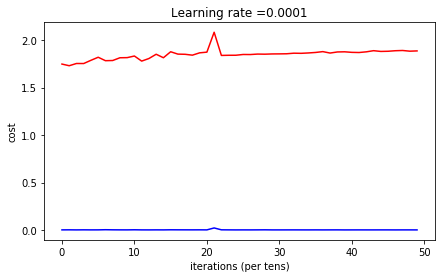

Parameters have been trained!
Train Accuracy: 1.0
Test Accuracy: 0.80833334


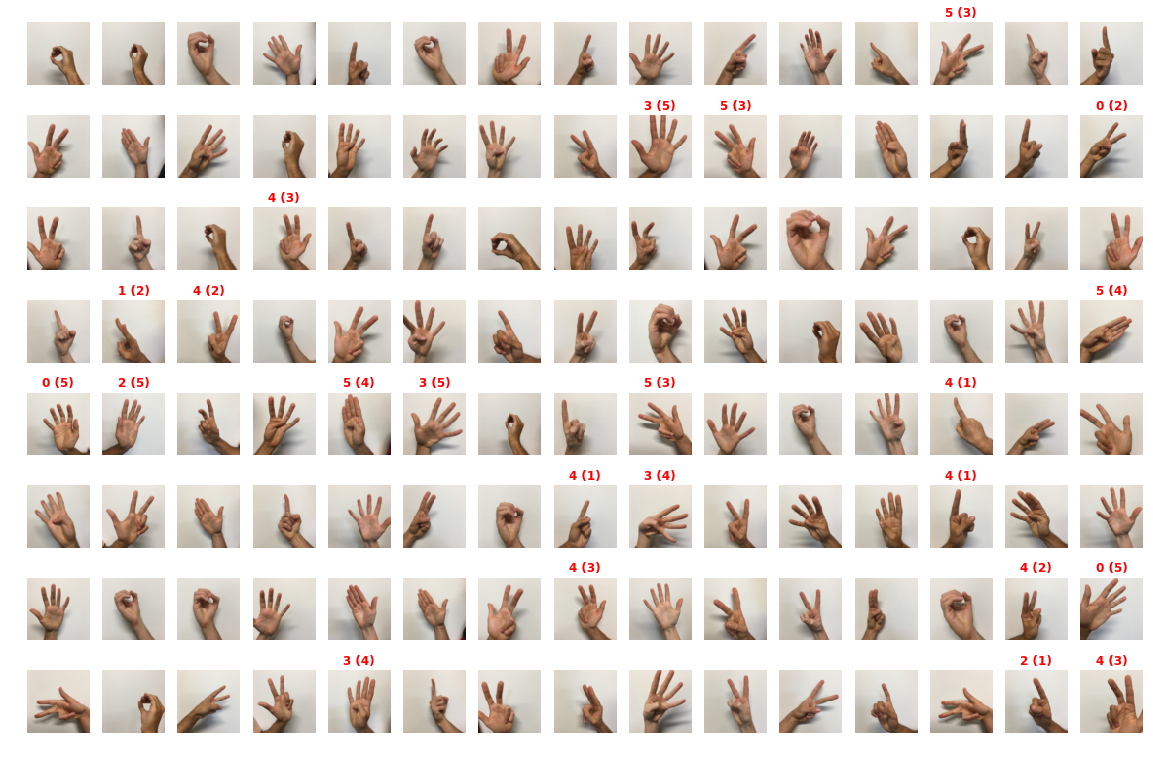

In [11]:
# 训练模型 实验发现关闭dropout训练效果较好
parameters = nn_model(X_train, Y_train, X_test, Y_test, layers_dims, parameters=parameters, 
                      num_epochs = 500, keep_prob = 1, print_cost=True)

In [12]:
# 将此次训练完毕的模型存入文件
try:
    fw = open('signs_parameters','wb')
    data = {'layers_dims' : layers_dims,
            'parameters' : parameters}
    pickle.dump(data, fw)
    fw.close()
except IOError:
    print("File is not accessible.")

### Batch Normalization

In [13]:
def nn_norm_model(X_train, Y_train, X_test, Y_test, layers_dims, parameters = None, learning_rate = 0.0001, 
             num_epochs = 1500, minibatch_size = 64, print_cost = False):
    # to be able to rerun the model without overwriting tf variables
    ops.reset_default_graph()

    # n_x: input size
    # m : number of examples in the train set
    # n_y : output size
    assert(X_train.shape[1] == Y_train.shape[1])
    n_x, m = X_train.shape
    n_y = Y_train.shape[0]
    L = len(layers_dims) - 1
    assert(n_x == layers_dims[0])
    assert(n_y == layers_dims[L])

    # To keep track of the cost
    costs_train = []
    costs_test = []

    # Create Placeholders of shape (n_x, n_y)
    X = tf.placeholder(tf.float32, shape=(n_x, None))
    Y = tf.placeholder(tf.float32, shape=(n_y, None))

    # Initialize parameters
    if parameters is None:
        parameters = {}
        for l in range(1, L + 1):
            parameters['W' + str(l)] = tf.get_variable('W' + str(l), [layers_dims[l], layers_dims[l - 1]], 
                                                       initializer = tf.contrib.layers.xavier_initializer())
            parameters['gamma' + str(l)] = tf.get_variable('gamma' + str(l), [layers_dims[l], 1], 
                                                       initializer = tf.ones_initializer())
            parameters['beta' + str(l)] = tf.get_variable('beta' + str(l), [layers_dims[l], 1], 
                                                       initializer = tf.zeros_initializer())
    else:
        for l in range(1, L + 1):
            parameters['W' + str(l)] = tf.get_variable('W' + str(l), [layers_dims[l], layers_dims[l - 1]], 
                                                       initializer = tf.constant_initializer(parameters['W' + str(l)]))
            parameters['gamma' + str(l)] = tf.get_variable('gamma' + str(l), [layers_dims[l], 1], 
                                                       initializer = tf.constant_initializer(parameters['gamma' + str(l)]))                 
            parameters['beta' + str(l)] = tf.get_variable('beta' + str(l), [layers_dims[l], 1], 
                                                       initializer = tf.constant_initializer(parameters['beta' + str(l)]))        

    # Forward propagation: Build the forward propagation in the tensorflow graph
    A = X
    for l in range(1, L):
        Z = parameters['W' + str(l)] @ A
        Z_mean, Z_var = tf.nn.moments(Z, list(range(len(Z.shape) - 1)))
        Z = tf.nn.batch_normalization(Z, mean=Z_mean, variance=Z_var, offset=parameters['beta' + str(l)], 
                                  scale=parameters['gamma' + str(l)], variance_epsilon=1e-7)
        A = tf.nn.relu(Z)
    Z = parameters['W' + str(L)] @ A
    Z_mean, Z_var = tf.nn.moments(Z, list(range(len(Z.shape) - 1)))
    Z = tf.nn.batch_normalization(Z, mean=Z_mean, variance=Z_var, offset=parameters['beta' + str(L)], 
                                  scale=parameters['gamma' + str(L)], variance_epsilon=1e-7)

    # Cost function: Add cost function to tensorflow graph
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=tf.transpose(Z), labels=tf.transpose(Y)))

    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer. 
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # alter: GradientDescentOptimizer

    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        # Run the initialization
        sess.run(init)

        # Do the training loop
        for epoch in range(num_epochs):
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)
            for minibatch in minibatches:
                minibatch_X, minibatch_Y = minibatch
                sess.run(optimizer, feed_dict={X: minibatch_X, Y: minibatch_Y})
            
            # Print the cost every epoch
            if print_cost and epoch % 10 == 0:
                epoch_cost_train = sess.run(cost, feed_dict={X: minibatch_X, Y: minibatch_Y})
                epoch_cost_test = sess.run(cost, feed_dict={X: X_test, Y: Y_test})
                costs_train.append(epoch_cost_train)
                costs_test.append(epoch_cost_test)
                if print_cost and epoch % 100 == 0:
                    print ("Cost after epoch %i: %f(train) %f(test)" % (epoch, epoch_cost_train, epoch_cost_test))
        
        # plot the cost
        if print_cost:
            plt.figure(figsize=(7.0, 4.0))
            plt.plot(np.squeeze(costs_train), color='blue')
            plt.plot(np.squeeze(costs_test), color='red')
            plt.ylabel('cost')
            plt.xlabel('iterations (per tens)')
            plt.title("Learning rate =" + str(learning_rate))
            plt.show()
            
        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")
        
        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        
        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        # Print all test images
        print_all_test_images(tf.argmax(Z).eval({X: X_test, Y: Y_test}), 
                              tf.argmax(Y).eval({X: X_test, Y: Y_test}))

        return parameters

In [14]:
# 从文件中读取上次训练完毕的模型
layers_dims = [X_train.shape[0], 25, 12, Y_train.shape[0]]
parameters = None

try:
    fr = open('signs_parameters_bn','rb')
    data = pickle.load(fr)
    layers_dims = data['layers_dims']
    parameters = data['parameters']
    fr.close()
except IOError:
    print("File is not accessible.")

Cost after epoch 0: 0.088662(train) 0.452752(test)
Cost after epoch 100: 0.979668(train) 1.329292(test)
Cost after epoch 200: 0.022440(train) 0.400676(test)
Cost after epoch 300: 0.015317(train) 0.344990(test)
Cost after epoch 400: 0.009835(train) 0.325624(test)


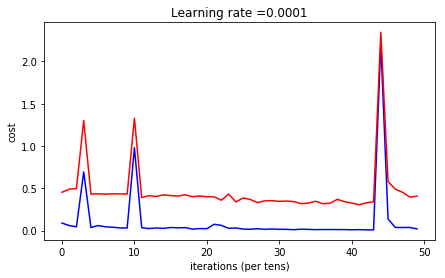

Parameters have been trained!
Train Accuracy: 0.9990741
Test Accuracy: 0.8833333


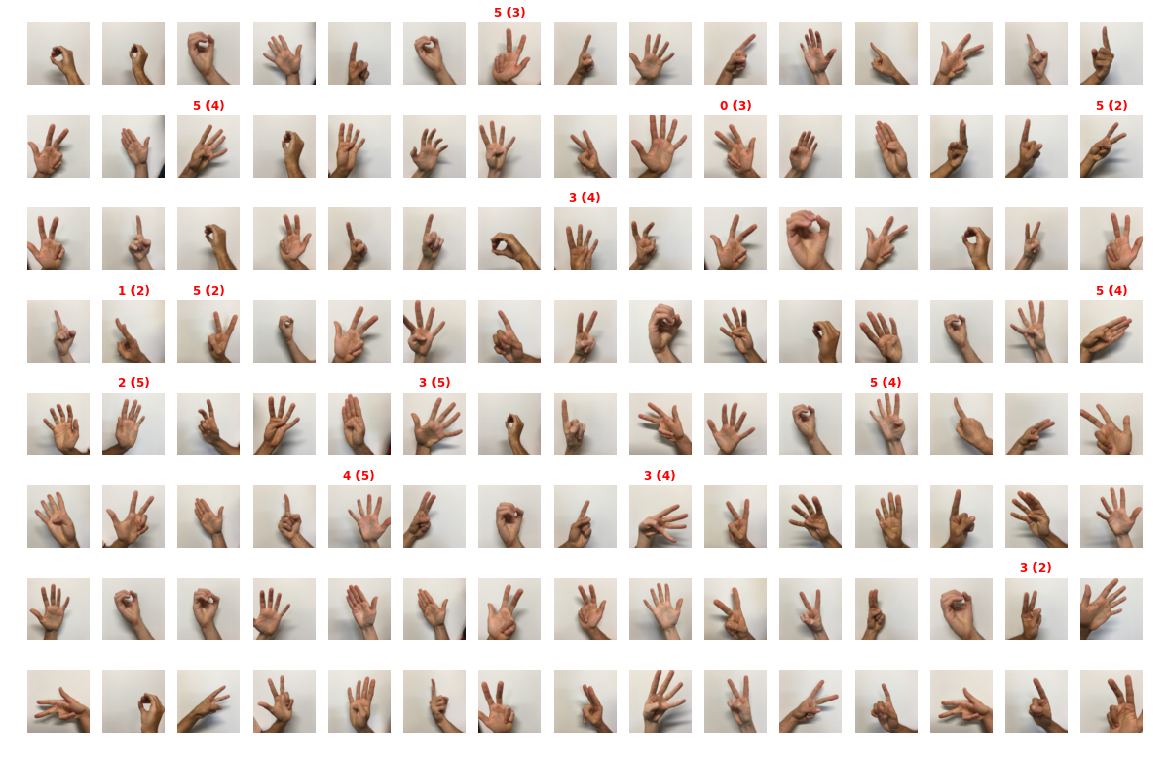

In [15]:
# 训练模型
parameters = nn_norm_model(X_train, Y_train, X_test, Y_test, layers_dims, parameters=parameters, 
                      num_epochs = 500, print_cost=True)

In [16]:
# 将此次训练完毕的模型存入文件
try:
    fw = open('signs_parameters_bn','wb')
    data = {'layers_dims' : layers_dims,
            'parameters' : parameters}
    pickle.dump(data, fw)
    fw.close()
except IOError:
    print("File is not accessible.")